In [1]:
import json

In [2]:
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcEnrichment, CalcAUC, CalcROC

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
t = pd.read_csv('results/random_split_0_new_pdbbind')

In [6]:
t.head()

,Unnamed: 0,all_targets,all_preds,all_losses,mean_loss,all_bioactive_rank,median_bioactive_rank,bioactive_accuracy,n_bioactive,n_generated,generated_accuracy,ccdc_accuracy,n_heavy_atoms,n_rotatable_bonds,ef20_pred,ef20_ccdc
0,NC(=O)c1cccn2c(-c3cccnc3)cnc12,"[0.0, 0.7137662, 0.92616934, 1.1124237, 1.3133...","[0.99028146, 0.81940424, 0.9173788, 0.81657207...","[0.9806573987007141, 0.01115939300507307, 7.72...",0.222892,[11],11.0,0.0,1.0,12.0,False,False,18.0,2.0,0.0,0.0
1,CC(=O)N1c2cccc(O)c2NC2=C(C(=O)CC(C)(C)C2)[C@@H...,"[0.0, 1.8106242, 1.9781741, 1.5160275, 1.68637...","[1.4584377, 1.7163965, 1.7032276, 1.3803257, 1...","[2.127040386199951, 0.008878876455128193, 0.07...",0.212874,[34],34.0,0.0,1.0,100.0,False,False,37.0,4.0,0.5,2.0
2,[NH3+]C[C@H]1CN(c2c(Br)cnc3[nH]ncc23)CCO1,"[0.0, 0.83138204, 1.8328137, 1.7206945, 1.1454...","[0.96140116, 1.472694, 0.82793045, 0.98893213,...","[0.9242922067642212, 0.4112810790538788, 1.009...",0.330547,[1],1.0,0.0,1.0,18.0,False,False,18.0,2.0,6.0,0.0
3,CC(=O)NCCc1ccc(S(N)(=O)=O)cc1,"[0.0, 0.0, 0.3358815, 0.56685805, 0.8557918, 0...","[0.6385325, 0.7259062, 0.9858687, 0.86888856, ...","[0.4077237844467163, 0.5269398093223572, 0.422...",0.059539,[1 8],4.5,0.5,2.0,100.0,False,False,16.0,4.0,3.0,0.5
4,Nc1ccc(CCC(=O)[O-])cc1,"[0.0, 0.96344984, 1.1145588, 0.98933554, 0.978...","[0.7523, 0.7809095, 0.64696497, 0.67861784, 0....","[0.5659553408622742, 0.03332098200917244, 0.21...",0.093036,[14],14.0,0.0,1.0,27.0,False,False,12.0,3.0,0.0,2.7


In [15]:
t[t['Unnamed: 0'] == 'Micro']

,Unnamed: 0,all_targets,all_preds,all_losses,mean_loss,all_bioactive_rank,median_bioactive_rank,bioactive_accuracy,n_bioactive,n_generated,generated_accuracy,ccdc_accuracy,n_heavy_atoms,n_rotatable_bonds,ef20_pred,ef20_ccdc
1109,Micro,NaN,NaN,NaN,0.45838,NaN,3.0,0.335954,NaN,NaN,0.11693171188026193,0.1019644527595884,NaN,NaN,1.987257,1.299393


In [7]:
all_targets = []
all_preds = []
all_activities = []
bedrocs_model = []
bedrocs_ccdc = []
bedrocs_random = []
ef_model = []
ef_ccdc = []
ef_random = []
auc_model = []
auc_ccdc = []
auc_random = []
n_rotatable_bonds = []
relative_ranks_model = []
relative_ranks_ccdc = []
relative_ranks_random = []
for mol_i in tqdm(range(len(t) - 1)) :
    
    targets = json.loads(t.iloc[mol_i, 1])
    targets = np.array(targets)
    generated = targets != 0
    generated_targets = targets[generated]
    if len(generated_targets) : 
        preds = json.loads(t.iloc[mol_i, 2])
        preds = np.array(preds)
        generated_preds = preds[generated]
        all_targets.extend(generated_targets)
        all_preds.extend(generated_preds)
        
        relative_ranks_model.extend(generated_preds.argsort().argsort() / len(generated_preds))
        ranks_ccdc = np.array(range(len(generated_preds)))
        relative_ranks_ccdc.extend(ranks_ccdc / len(generated_preds))
        np.random.shuffle(ranks_ccdc)
        relative_ranks_random.extend(ranks_ccdc / len(generated_preds))

        actives_i = np.argsort(generated_targets)[:int(len(generated_targets) / 10)]
        activity = [True if i in actives_i else False for i in range(len(generated_preds))]
        all_activities.extend(activity)
        preds_array = np.array(list(zip(preds, activity)))
        sorting = np.argsort(preds_array[:, 0])
        sorted_preds_array = preds_array[sorting]

        ef_model.append(CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])[0])
        bedrocs_model.append(CalcBEDROC(sorted_preds_array, col=1, alpha=20))
        auc_model.append(CalcAUC(sorted_preds_array, col=1))

        ef_ccdc.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_ccdc.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_ccdc.append(CalcAUC(preds_array, col=1))
        
        np.random.shuffle(preds_array)
        ef_random.append(CalcEnrichment(preds_array, col=1, fractions=[0.2])[0])
        bedrocs_random.append(CalcBEDROC(preds_array, col=1, alpha=20))
        auc_random.append(CalcAUC(preds_array, col=1))
        
        
        n_rotatable_bonds.append(int(t.loc[mol_i, 'n_rotatable_bonds']))
        
        model_roc = CalcROC(sorted_preds_array, col=1)
        ccdc_roc = CalcROC(preds_array, col=1)
        
#         plt.plot(model_roc.FPR, model_roc.TPR, label='model')
#         plt.plot(ccdc_roc.FPR, ccdc_roc.TPR, label='ccdc')
#         plt.legend()
#         plt.show()

100%|█████████████████████████████████████| 1109/1109 [00:00<00:00, 1322.64it/s]


In [8]:
thresholds = [n for n in np.arange(0, 1, 0.01)]
retrieved_ccdc = []
retrieved_model = []
retrieved_random = []
relative_ranks_ccdc = np.array(relative_ranks_ccdc)
relative_ranks_model = np.array(relative_ranks_model)
relative_ranks_random = np.array(relative_ranks_random)
all_activities = np.array(all_activities)
n_actives = sum(all_activities)
for threshold in tqdm(thresholds) :
    ccdc_below_threshold = relative_ranks_ccdc < threshold
    retrieved_ccdc.append(sum(all_activities * ccdc_below_threshold) / n_actives)
    model_below_threshold = relative_ranks_model < threshold
    retrieved_model.append(sum(all_activities * model_below_threshold) / n_actives)
    random_below_threshold = relative_ranks_random < threshold
    retrieved_random.append(sum(all_activities * random_below_threshold) / n_actives)

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


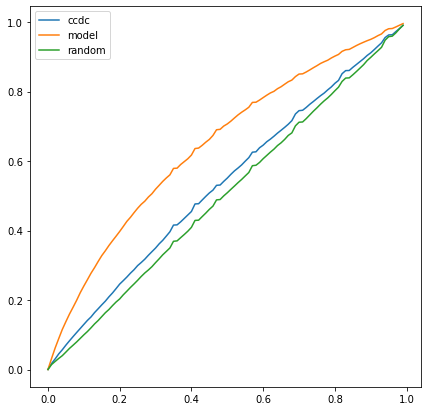

In [9]:
plt.figure(figsize=(7,7))
plt.plot(thresholds, retrieved_ccdc, label='ccdc')
plt.plot(thresholds, retrieved_model, label='model')
plt.plot(thresholds, retrieved_random, label='random')
plt.legend()

In [66]:
actives_i = np.argsort(all_targets)[:int(len(all_targets) / 10)]
activity = [True if i in actives_i else False for i in range(len(all_preds)) ]

In [88]:
np.array(all_targets)[all_activities]

array([0.2511729 , 0.22680886, 0.71707267, ..., 0.70647025, 0.7089684 ,
       0.6722265 ])

<AxesSubplot:ylabel='Count'>

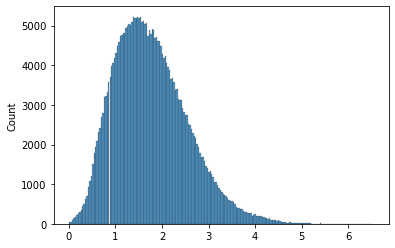

In [89]:
sns.histplot(all_targets)

In [92]:
preds_array = np.array(list(zip(all_preds, all_activities)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

<AxesSubplot:ylabel='Count'>

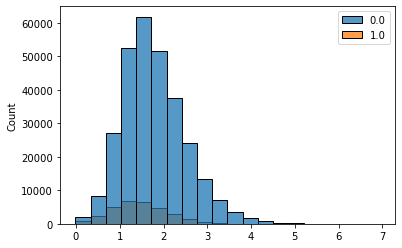

In [93]:
sns.histplot(x=preds_array[:,0], hue=preds_array[:,1], bins=20)

In [94]:
CalcEnrichment(sorted_preds_array, col=1, fractions=[0.2])

[1.700708103855232]

In [95]:
CalcEnrichment(preds_array, col=1, fractions=[0.2])

[0.9954366640440598]

In [102]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

0.24069664397927673

In [103]:
CalcBEDROC(preds_array, col=1, alpha=20)

0.1134974781646219

In [75]:
np.mean(bedrocs_model)

0.13741205695861364

In [76]:
np.mean(bedrocs_ccdc)

0.1513573172965136

In [77]:
np.mean(bedrocs_random)

0.09493902839323147

In [78]:
np.median(bedrocs_model)

0.06423589177317035

In [79]:
np.median(bedrocs_ccdc)

0.07005740670894449

In [80]:
np.median(bedrocs_random)

0.04291484633758817

In [81]:
np.mean(ef_model)

1.1311891746614382

In [82]:
np.mean(ef_ccdc)

1.1717195849361122

In [83]:
np.mean(ef_random)

0.8456513863080962

In [84]:
np.mean(auc_model)

0.46972384114273397

In [85]:
np.mean(auc_ccdc)

0.4756124061784957

In [86]:
np.mean(auc_random)

0.42078305669953797

<AxesSubplot:>

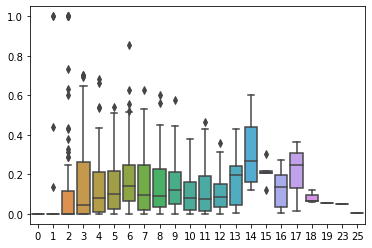

In [78]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_model)

<AxesSubplot:>

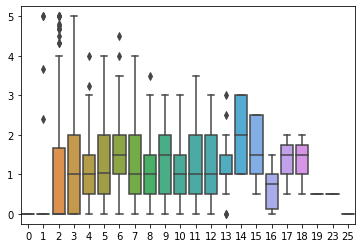

In [92]:
sns.boxplot(x=n_rotatable_bonds, y=ef_model)

<AxesSubplot:>

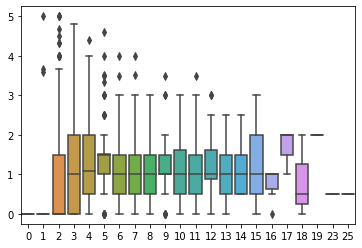

In [93]:
sns.boxplot(x=n_rotatable_bonds, y=ef_ccdc)

<AxesSubplot:>

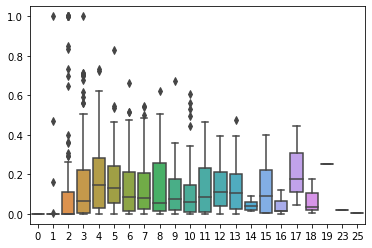

In [79]:
sns.boxplot(x=n_rotatable_bonds, y=bedrocs_ccdc)

In [35]:
actives_i = np.argsort(targets)[:int(len(targets) / 10)]
activity = [True if i in actives_i else False for i in range(len(preds)) ]

In [36]:
preds_array = np.array(list(zip(preds, activity)))
sorting = np.argsort(preds_array[:, 0])
sorted_preds_array = preds_array[sorting]

In [37]:
CalcBEDROC(sorted_preds_array, col=1, alpha=20)

0.0

In [38]:
CalcBEDROC(preds_array, col=1, alpha=20)

0.0

In [39]:
t_nomicro = t.dropna(subset=['n_heavy_atoms']).copy()
t_nomicro['n_heavy_atoms'] = t_nomicro['n_heavy_atoms'].astype(int)
t_nomicro['n_rotatable_bonds'] = t_nomicro['n_rotatable_bonds'].astype(int)

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_rotatable_bonds'>

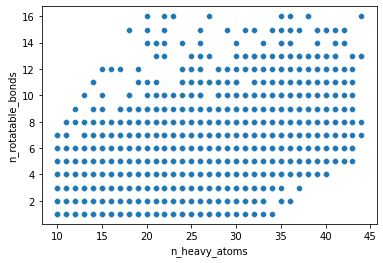

In [40]:
#plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_heavy_atoms', y='n_rotatable_bonds')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='mean_loss'>

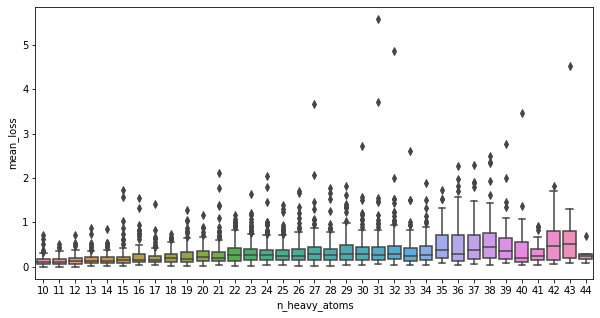

In [21]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='mean_loss')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='mean_loss'>

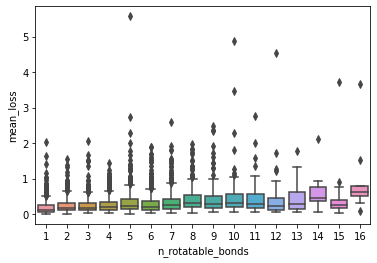

In [22]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='mean_loss')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_bioactive'>

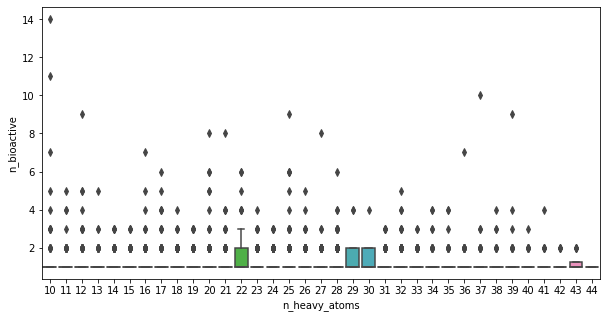

In [38]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_bioactive')

<AxesSubplot:xlabel='n_generated', ylabel='Count'>

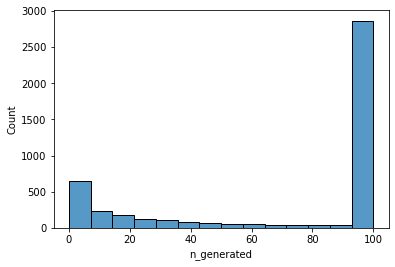

In [46]:
sns.histplot(data=t_nomicro, x='n_generated')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='n_generated'>

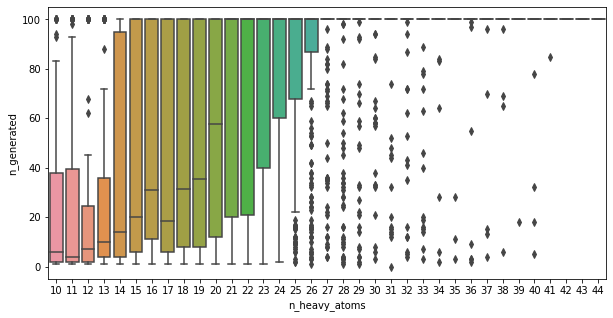

In [39]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='n_generated')

<AxesSubplot:xlabel='n_generated', ylabel='mean_loss'>

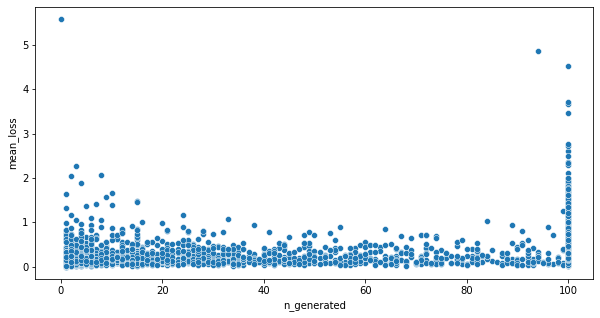

In [47]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_generated', y='mean_loss')

<AxesSubplot:xlabel='n_bioactive', ylabel='bioactive_accuracy'>

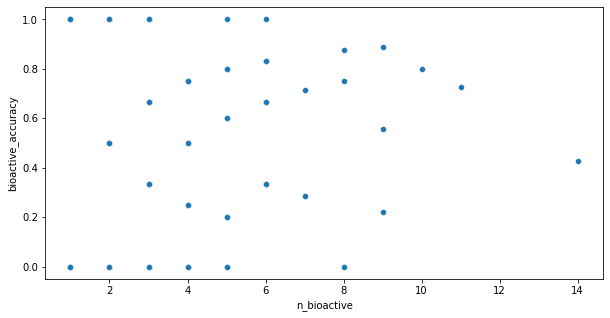

In [48]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='bioactive_accuracy')

<AxesSubplot:xlabel='n_bioactive', ylabel='median_bioactive_rank'>

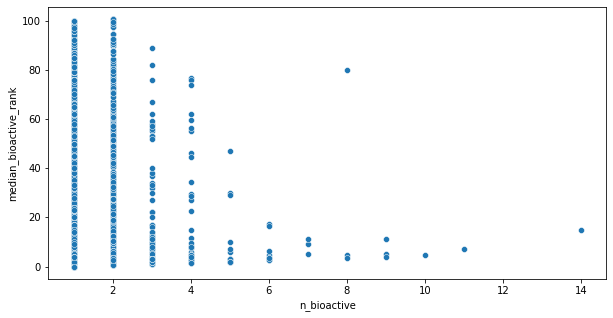

In [49]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=t_nomicro, x='n_bioactive', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_heavy_atoms', ylabel='median_bioactive_rank'>

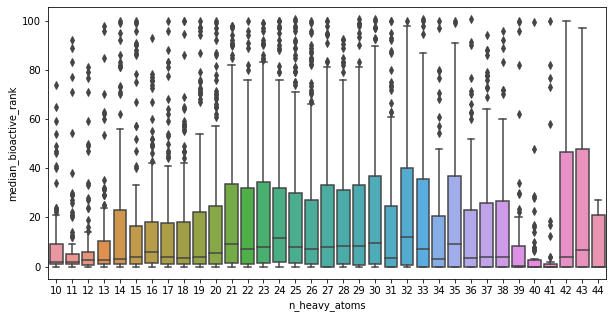

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_heavy_atoms', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='median_bioactive_rank'>

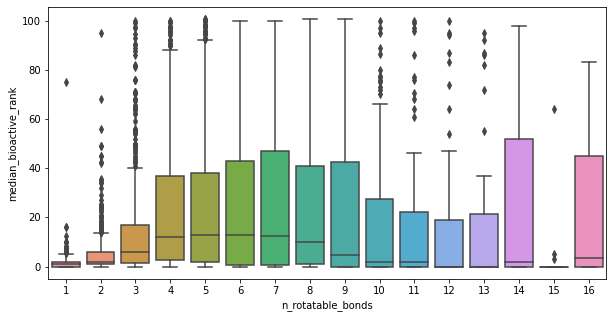

In [75]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='ef20_ccdc'>

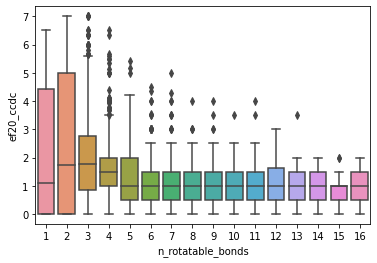

In [50]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_ccdc')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='ef20_pred'>

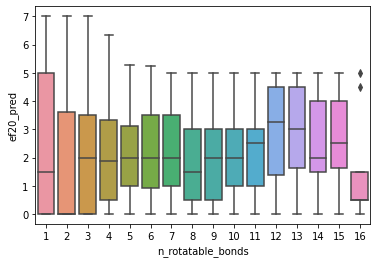

In [53]:
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='ef20_pred')

<AxesSubplot:xlabel='ef20_ccdc', ylabel='ef20_pred'>

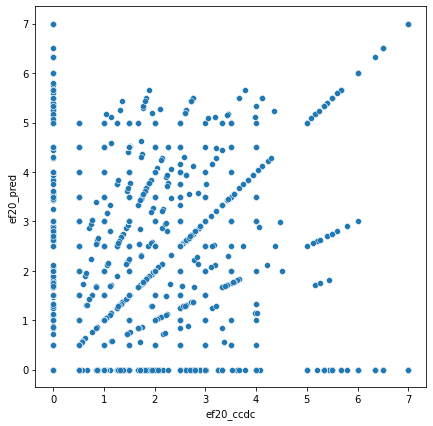

In [82]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=t_nomicro, x='ef20_ccdc', y='ef20_pred')

<AxesSubplot:xlabel='ef20_ccdc', ylabel='ef20_pred'>

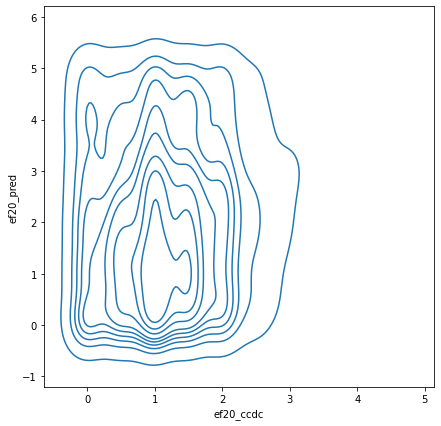

In [86]:
t_100gen = t_nomicro[t_nomicro['n_generated'] == 100]
plt.figure(figsize=(7,7))
sns.kdeplot(data=t_100gen, x='ef20_ccdc', y='ef20_pred')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_ccdc'>

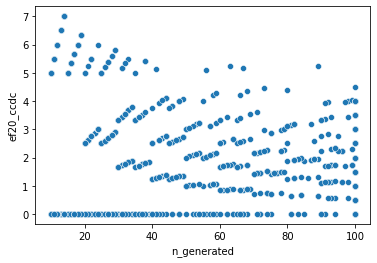

In [57]:
sns.scatterplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_pred'>

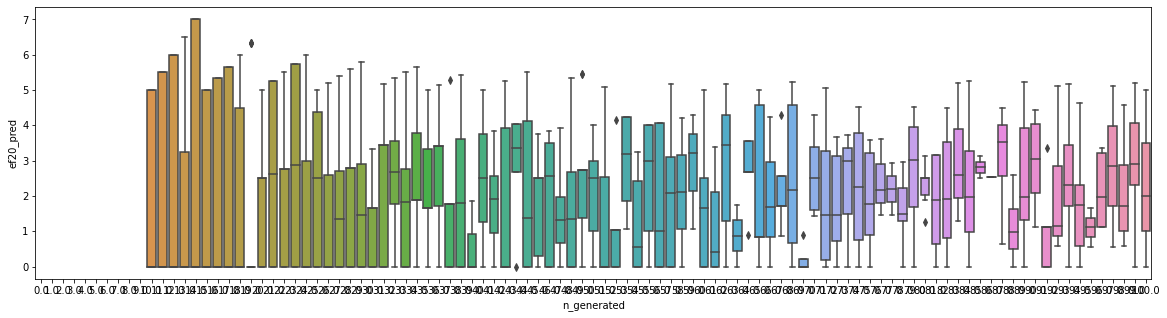

In [60]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_pred')

<AxesSubplot:xlabel='n_generated', ylabel='ef20_ccdc'>

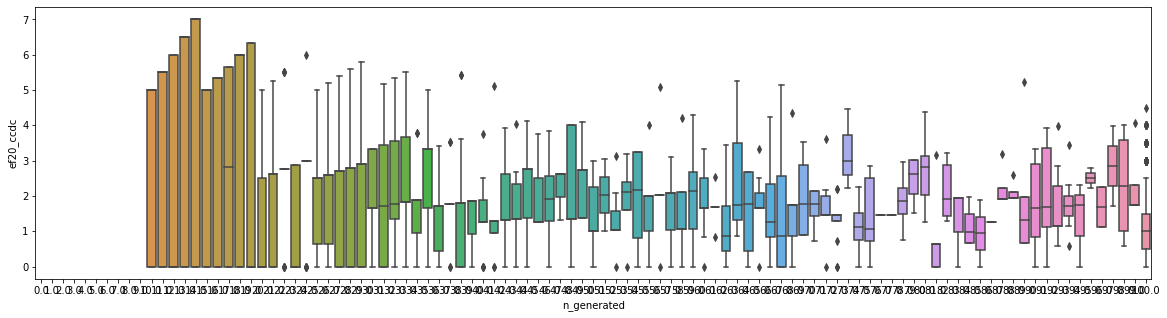

In [61]:
plt.figure(figsize=(20,5))
sns.boxplot(data=t_nomicro, x='n_generated', y='ef20_ccdc')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='median_bioactive_rank'>

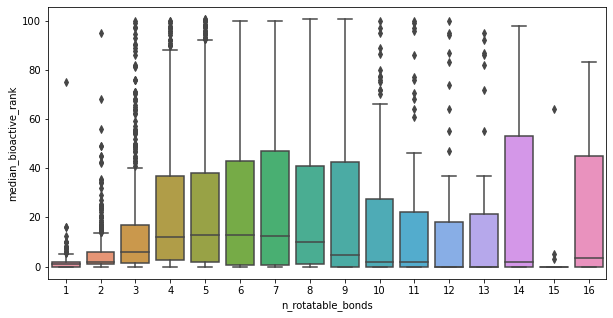

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='median_bioactive_rank')

<AxesSubplot:xlabel='n_rotatable_bonds', ylabel='bioactive_accuracy'>

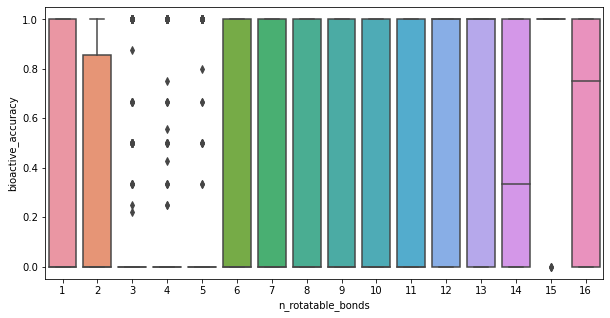

In [28]:
plt.figure(figsize=(10,5))
sns.boxplot(data=t_nomicro, x='n_rotatable_bonds', y='bioactive_accuracy')